# Day 1 - Comparisons: Part-to-whole

Lately I've been playing Tradle, a game similar to Worldle but instead of country silhouettes it uses a treemap of the country's exports, as well as a total annual export value in USD. Tradle uses OEC (Observatory of Economic Complexity) data as a source.

I'll be recreating that treemap for Guam.

## Data Source
The OEC website has a web-based visualizer and luckily Guam is considered a sovereign country by OEC so it has its own data separate from the United States. An example treemap of Guam can be found [here](https://oec.world/en/visualize/tree_map/hs92/export/gum/all/show/2020/).

However it seems like a premium account is needed to download the data used to create the treemap. The source of the data is listed as 'HS6 REV. 1992 (1995 - 2020)' which leads to a database called BACI, maintained by the French economic think tank CEPII. This database uses Comtrade data from the UN, but performs some data cleaning described [here](http://www.cepii.fr/PDF_PUB/wp_nts/2010/wp2010-23.pdf).

## Harmonized System
The data is available in several categorizations of the Harmonized System (HS). HS was developed by the World Customs Organization to break down trade goods into several levels of categories in order to standardize international trade statistics. There have been several changes to the HS categories every several years and the BACI data is available in HS92, HS96, HS02, HS07, HS12, and HS17 categorizations. The categories become more numerous and complex with each subsequent change, and viewing the data in the OEC visualizer shows that Tradle uses HS92 and it provides plenty of detail and categories, so I will move forward with that dataset.

## BACI Data
The full 2022 HS92 BACI database was a 2.1GB ZIP file of CSV files which I won't include in this repository. I will include my cleaned CSV file that only include Guam's imports and exports and the simple script I used to create that file.

In order to process the data, Guam's country code and the HS97 product codes must be known. These can be found on the UN website.

* [Country Codes](https://comtrade.un.org/data/cache/partnerAreas.json)
* [Product Codes](https://comtrade.un.org/data/cache/classificationH0.json)

Both files are included in the day 1 folder.

The structure of the CSV file is 6 columns representing the year, exporter, importer, product, value, and quantity. Each line represents a yearly total of a single HS92 category from a single exporter to a single importer. The 2020 HS92 file has 10,031,112 rows.

## Data Structure
Here are the first 10 lines of the 2020 HS92 BACI CSV file:
```

2020,4,32,391000,       0.044,        0.009
2020,4,32,401010,       0.164,           NA
2020,4,32,610120,       0.012,        0.003
2020,4,36,071120,       0.718,        0.308
2020,4,36,071290,       0.665,        0.500
2020,4,36,080211,       2.377,        0.710
2020,4,36,080420,       1.342,        1.331
2020,4,36,080620,     523.628,      326.501
```

Here is an example country from the `partnerAreas.json`
```
        {
            "id": "316",
            "text": "Guam"
        },
```

Here is an example heirarchy of product codes from the `classificationH0.json`
```
	{
		"id": "01",
		"text": "01 - Animals; live",
		"parent": "TOTAL"
	},
	{
		"id": "0101",
		"text": "0101 - Horses, asses, mules and hinnies; live",
		"parent": "01"
	},
	{
		"id": "010111",
		"text": "010111 - Horses; live, pure-bred breeding animals",
		"parent": "0101"
	},
```

## Creating the Treemap

### Imports vs Exports

The first task is to determine imports vs exports. A single boolean column is used for now, and the importer and exporter columns are no longer needed, so they are deleted. The year and quantity column also aren't necessary so they are removed.

In [159]:
import pandas as pd

trade_filename = "guam_import_export_2020_HS92.csv"
country_code_filename = "partnerAreas.json"
product_code_filename = "classificationH0.json"
guam_code = 316

df = pd.read_csv(trade_filename, names=["year", "exporter", "importer", "product", "value", "quantity"], dtype=str)

df['guam_export'] = (df['exporter'] == "316")
df = df.drop(['exporter', 'importer', 'year', 'quantity'], axis=1)
df['value'] = df['value'].astype(float)

print(df)
print(df.dtypes)

     product    value  guam_export
0     030614    4.543        False
1     040110   21.787        False
2     040120  946.177        False
3     040299   11.537        False
4     080290   97.954        False
...      ...      ...          ...
5520  940540   13.613        False
5521  950390    3.426        False
5522  950590    2.048        False
5523  950691    5.249        False
5524  950699    5.345        False

[5525 rows x 3 columns]
product         object
value          float64
guam_export       bool
dtype: object


### Rolling Up Country Imports/Exports by Product Code

The treemap won't distinguish between which country Guam is importing from or exporting to, so imports and exports should be rolled up into one product code for import/export and the country code removed.

In [160]:
grouped = df.groupby(["product", "guam_export"], as_index=False)
df = grouped.sum()

print(df)

     product  guam_export     value
0     010600         True     0.939
1     020230        False   963.353
2     020319        False   496.085
3     020322        False    58.739
4     020329        False  1707.156
...      ...          ...       ...
2153  961620        False     1.410
2154  961700        False     8.552
2155  961800        False     4.768
2156  970110        False     0.057
2157  970400         True     0.420

[2158 rows x 3 columns]


### Rolling Up Product Codes by Parent

The lowest level product codes are too fine-grained for a useful chart so the data will be grouped by the mid-level (4 digit) product codes with a column for the parent code (2 digit). This is similar to Tradle's display. In a 6 digit code, the top level is the first two digits, and the mid-level is the middle two digits.

In [161]:
df['product'] = df['product'].apply(lambda x: x[:4])

grouped = df.groupby(["product", "guam_export"], as_index=False)
df = grouped.sum()

df['parent'] = df['product'].apply(lambda x: x[:2])

print(df)
print(df[df['product'] == "1905"])

    product  guam_export     value parent
0      0106         True     0.939     01
1      0202        False   963.353     02
2      0203        False  2261.980     02
3      0204        False    30.931     02
4      0206        False   179.595     02
..      ...          ...       ...    ...
923    9616        False     1.410     96
924    9617        False     8.552     96
925    9618        False     4.768     96
926    9701        False     0.057     97
927    9704         True     0.420     97

[928 rows x 4 columns]
    product  guam_export     value parent
109    1905        False  5060.103     19
110    1905         True     7.776     19


### Swapping product and parent codes with descriptions

Now the numeric HS codes which are stored as strings can be swapped with their full descriptions.

In [162]:
import json

with open(product_code_filename, 'r') as f:
    product_codes = json.load(f)
    
text_map = {}
for product in product_codes['results']:
    # The product code is repeated in the beginning of the description, split removes that.
    # Example description: "0101 - Horses, asses, mules and hinnies; live"
    description = product["text"].split(" - ", maxsplit=1)[1]
    description = description.split(";", maxsplit=1)[0]
    text_map[product["id"]] = description

df['parent'] = df['parent'].replace(text_map)
df['product'] = df['product'].replace(text_map)

print(df)

                                               product  guam_export     value  \
0                        Animals, n.e.s. in chapter 01         True     0.939   
1                               Meat of bovine animals        False   963.353   
2                                        Meat of swine        False  2261.980   
3                               Meat of sheep or goats        False    30.931   
4    Edible offal of bovine animals, swine, sheep, ...        False   179.595   
..                                                 ...          ...       ...   
923  Scent sprays and similar toilet sprays and mou...        False     1.410   
924  Vacuum flasks and other vacuum vessels, comple...        False     8.552   
925             Tailors' dummies and other lay figures        False     4.768   
926  Paintings, drawings, pastels, executed entirel...        False     0.057   
927                         Stamps, postage or revenue         True     0.420   

                           

### Sorting and Limiting Data

The data needs to be split into both imports and exports based on the previously made boolean column and then the product and parent columns can be used for the treemap heirarchy and the value column will determine the size.

Also, the values will be sorted by descending value, and only the top values will be kept for plotting.

In [163]:
maximum_products = 20

# split the dataframe into 2 dataframes, imports and exports.
# Only include top 100 values
import_df = df[(df['guam_export'] == False)]
total_imports_M = int(import_df['value'].sum() // 1E3)
import_df = import_df.nlargest(maximum_products, 'value')

export_df = df[(df['guam_export'] == True)]
total_exports_M = int(export_df['value'].sum() // 1E3)
export_df = export_df.nlargest(maximum_products, 'value')

/home/koalefant/.local/share/virtualenvs/30-day-chart-2022-OzY2epYN/lib/python3.10/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/koalefant/.local/share/virtualenvs/30-day-chart-2022-OzY2epYN/lib/python3.10/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



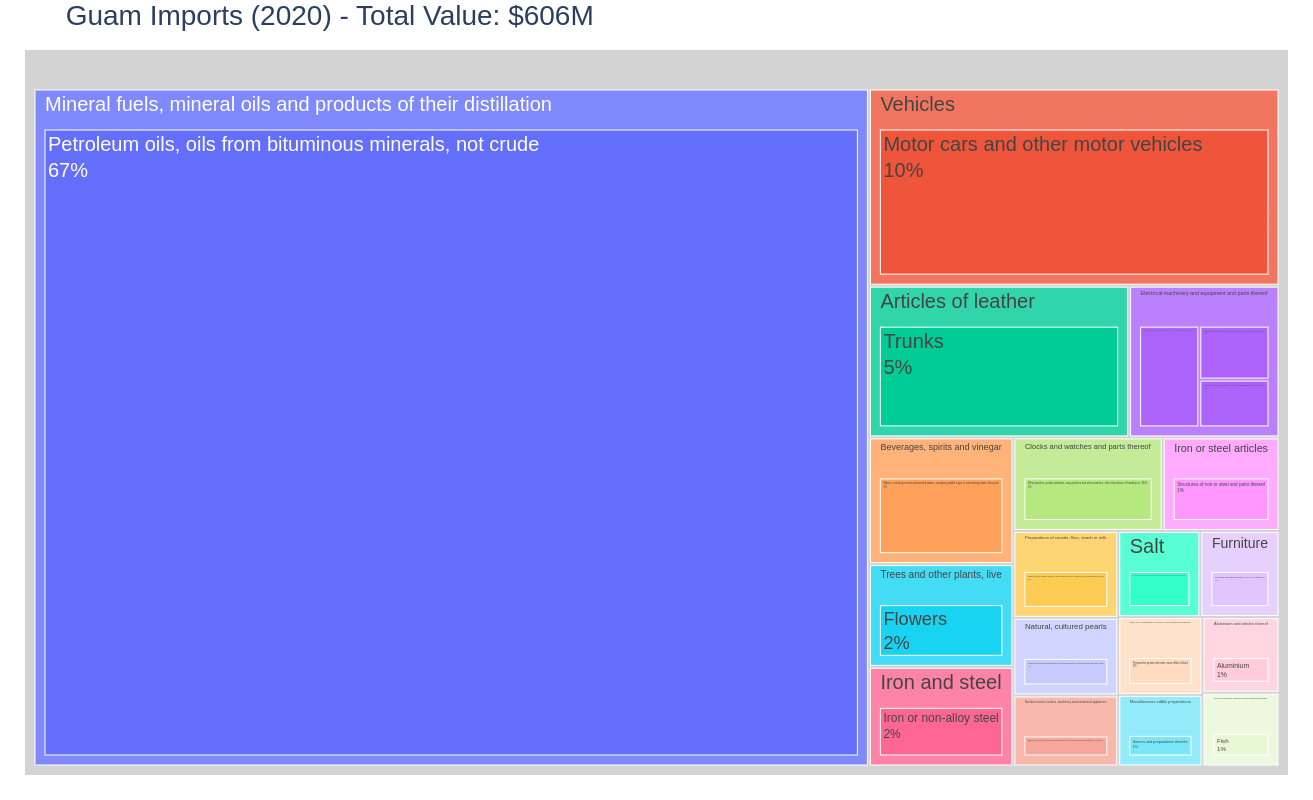

In [164]:
import plotly.express as px

fig = px.treemap(import_df, 
                 path=['parent', 'product'],
                 values='value')
fig.update_traces(root_color='lightgrey',
                  textinfo='label+percent root')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),
                  font_size=20,
                  title = dict(text=f'Guam Imports (2020) - Total Value: ${total_imports_M}M'),
                  height = 800)
fig.show()

/home/koalefant/.local/share/virtualenvs/30-day-chart-2022-OzY2epYN/lib/python3.10/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/koalefant/.local/share/virtualenvs/30-day-chart-2022-OzY2epYN/lib/python3.10/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



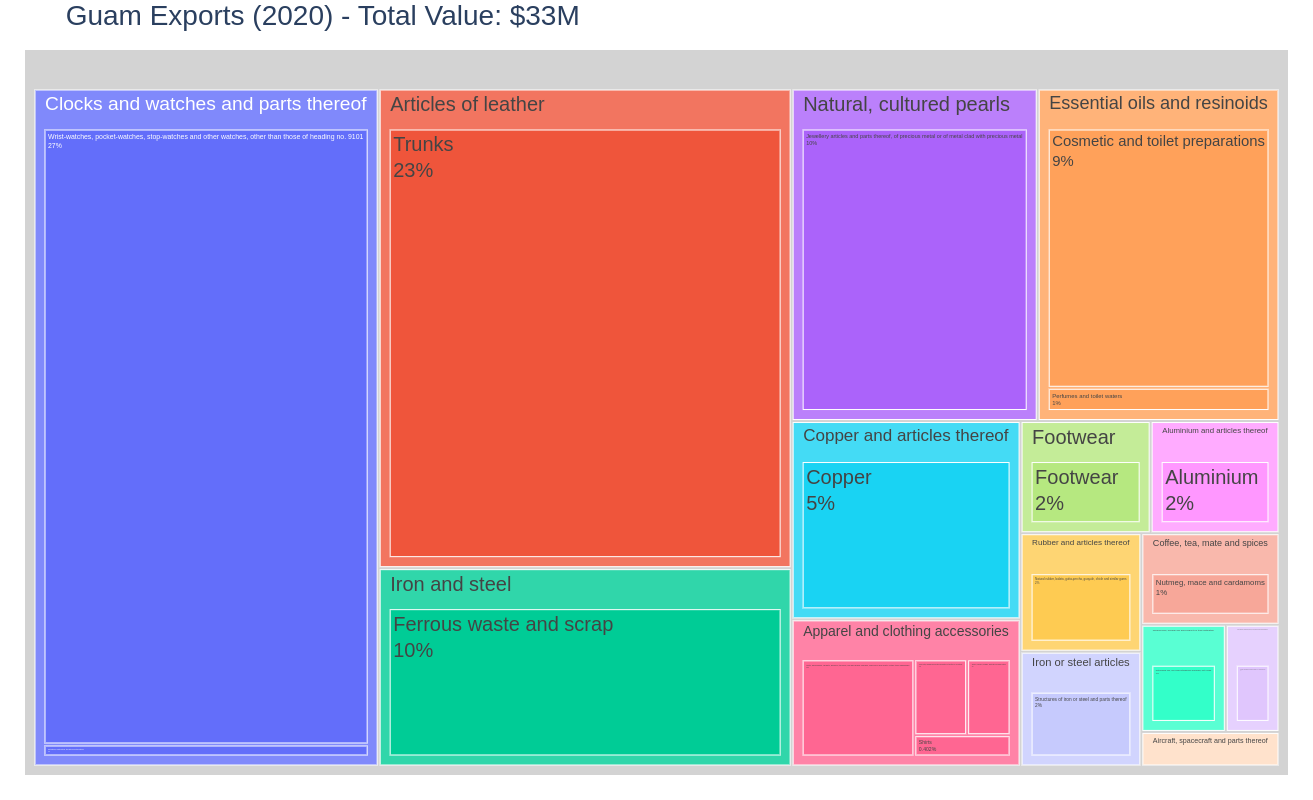

In [165]:
import plotly.express as px

fig = px.treemap(export_df, 
                 path=['parent', 'product'],
                 values='value')
fig.update_traces(root_color='lightgrey',
                  textinfo='label+percent root')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),
                  font_size=20,
                  title = dict(text=f'Guam Exports (2020) - Total Value: ${total_exports_M}M'),
                  height = 800)
fig.show()